In [1]:
!pip install torch
!pip install keras-tuner
!pip install pyzipcode
!pip install uszipcode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyzipcode: filename=pyzipcode-3.0.1-py3-none-any.whl size=1932413 sha256=22a4337cd6d5161eb0257d29a6ae5840bf830d14222daa59e8e2589e54c235de
  Stored in directory: /root/.cache/pip/wheels/f6/01/8e/7424c7e867eb5db7bb9531b09b4d968f23e5ac45ec5e7c3cb3
Successfully built pyzipcode
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Get the data from Movielens website
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import random
import keras_tuner as kt
from pyzipcode import ZipCodeDatabase
import tensorflow_probability as tfp
from time import time
import torch.nn.functional as F



import warnings
warnings.filterwarnings('ignore')

## Data preparation

In [3]:

# url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
# data_dir = 'ml-1m/'

url = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
data_dir = 'ml-100k/'



urlretrieve(url, "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read(data_dir+ 'u.info'))

Done. Dataset contains:
b'943 users\n1682 items\n100000 ratings\n'


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
!cat $data_dir/README

SUMMARY & USAGE LICENSE

MovieLens data sets were collected by the GroupLens Research Project
at the University of Minnesota.
 
This data set consists of:
	* 100,000 ratings (1-5) from 943 users on 1682 movies. 
	* Each user has rated at least 20 movies. 
        * Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the MovieLens web site
(movielens.umn.edu) during the seven-month period from September 19th, 
1997 through April 22nd, 1998. This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set. Detailed descriptions of
the data file can be found at the end of this file.

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under th

In [6]:
def normalize_col(df,col_name):
	df[col_name] = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
	return df

def get_genres(movies, genres, genres_encoded):
		def get_all_genres(gs):
			active = [str(genres_encoded[genre]) for genre, g in zip(genres, gs) if g==1]
			if len(active) == 0:
				return '0'
			return ','.join((active))
		
		movies['all_genres'] = [
		get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]	

In [7]:
class Dataset(object):
	def __init__(self):
		# retrieve users df
		users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
		self.users = pd.read_csv(data_dir + 'u.user', sep='|', names=users_cols, encoding='latin-1')

		# The movies file contains a binary feature for each genre.
		self.genre_cols = [
			"genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
			"Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
			"Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western",
		]
		movies_cols = [
			'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
		] + self.genre_cols

		# retrieve movies df
		movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
		movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
		movies['movie_name'] = movies['title'].str[:-6]
		movies['example_age'] = (pd.to_datetime("now") - pd.to_datetime(movies['release_date']))\
					/np.timedelta64(1,'D')
		self.movies = movies

		# retrieve ratings df
		ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
		self.ratings = pd.read_csv(
		'ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')
	
		# set the predicted label as the last "watched" movie
		watched_items = self.ratings[self.ratings['rating'] >= 3]
		self.predicted_labels = watched_items.loc[watched_items.groupby('user_id').unix_timestamp.idxmax()][['user_id', 'movie_id']].set_index(['user_id']).reset_index()
		filter = self.ratings.merge(self.predicted_labels, on=['user_id','movie_id'], 
                   how='left', indicator=True)
		self.ratings = self.ratings[filter['_merge'] == 'left_only']
		self.predicted_labels = self.predicted_labels.rename(columns={"user_id": "user_id", "movie_id": "predict_labels"})
	
	

		# create search and watch history- we are generating this df's based on the user rating history
		# Generate the search history dataframe (all movies the user gave a rating for)
		users_ratings = pd.merge(self.ratings,movies, how='left')
		searches = users_ratings[['user_id','movie_name']].reset_index(drop=True)
		searches.rename(columns={'user_id':'user','movie_name':'search_hist'}, inplace=True)
		self.searches = searches.drop_duplicates()
	
    # Generate the watch history dataframe (all movies the user rated more than 3)
		watches = self.ratings[self.ratings['rating'] >= 3][['user_id','movie_id']].reset_index(drop=True)
		self.watches = watches.drop_duplicates()
		self.preprocess()
	
	def preprocess(self):
		self.movies = normalize_col(self.movies,'example_age')
		data = self.watches.merge(self.movies, on='movie_id').merge(self.users, on='user_id')
		movie_ids = self.movies[['movie_id']]	
		data['user_id']=data['user_id'].astype(int)
		data['movie_id']=data['movie_id'].astype(int)
		data = data.set_index(['user_id']).sort_index()
		data = data.reset_index()
		data['movie_name'] = data['title'].str[:-6]
		labels = self.predicted_labels
		labels['user_id']=labels['user_id'].astype(int)
		labels['predict_labels']=labels['predict_labels'].astype(int)
		zcdb = ZipCodeDatabase()
		data['state'] = data["zip_code"].map(lambda x: zcdb[x].state if x in zcdb else None)

		#encoding
		# occupation
		occupations = data["occupation"].unique().tolist()
		occupations_encoded = {x: i for i, x in enumerate(occupations, start=1)}

    # user
		user_ids = data["user_id"].unique().tolist()
		user2user_encoded = {x: i for i, x in enumerate(user_ids, start=1)}

		# search history
		search_hists = self.searches["search_hist"].unique().tolist()
		search_encoded = {x: i for i, x in enumerate(search_hists, start=1)}

		# example age
		example_age = self.movies["example_age"].unique().tolist()
		example_age_encoded = {x: i for i, x in enumerate(example_age, start=1)}

		#state
		states = data["state"].unique().tolist()
		states_encoded = {x: i for i, x in enumerate(states, start=1)}

		# movie
		movie_ids = movie_ids['movie_id'].unique().tolist()
		movie2movie_encoded = {x: i for i, x in enumerate(movie_ids, start=1)}
	
		# title
		title_ids = self.movies["title"].unique().tolist()
		title2title_encoded = {x: i for i, x in enumerate(title_ids, start=1)}
		# print(len(title2title_encoded))

		# sex
		sex_ids = data["sex"].unique().tolist()
		sex_encoded = {x: i for i, x in enumerate(sex_ids, start=1)}


		# genre
		genres_encoded = {x: i for i, x in enumerate(self.genre_cols)}



		global SEARCH_DIM, WATCH_DIM, EXAMPLE_AGE_DIM, DISLIKED_DIM,LIKED_DIM, GENRE_DIM,TITLE_DIM, CANDIDATE_DIM, SEX_DIM, STATES_DIM
		SEARCH_DIM = len(search_encoded)
		WATCH_DIM = len(movie2movie_encoded)
		EXAMPLE_AGE_DIM = len(example_age_encoded)
		DISLIKED_DIM = len(movie2movie_encoded)
		LIKED_DIM = len(movie2movie_encoded)
		GENRE_DIM = len(genres_encoded)
		TITLE_DIM = len(title2title_encoded)
		CANDIDATE_DIM = len(movie2movie_encoded)
		SEX_DIM = len(sex_encoded)
		STATES_DIM = len(states_encoded)

		#
		self.movie2movie_encoded = movie2movie_encoded
		data["user"] = data["user_id"].map(user2user_encoded)
		data["movie"] = data["movie_id"].map(movie2movie_encoded)
		self.ratings["movie_id"] = self.ratings["movie_id"].map(movie2movie_encoded)
		data["title_d"] = data["title"].map(title2title_encoded)
		labels["user_id"] = labels["user_id"].map(user2user_encoded)
		labels["predict_labels"] = labels["predict_labels"].map(movie2movie_encoded)
		self.searches["search_hist"] = self.searches["search_hist"].map(search_encoded)
		data["occupation"] = data["occupation"].map(occupations_encoded)
		data["state"] = data["state"].map(states_encoded)
		data["sex"] = data["sex"].map(sex_encoded)
		data["example_age"] = data["example_age"].map(example_age_encoded)
		self.labels = labels


		watch_hist = data.groupby(['user'])['movie'].apply(list).reset_index()
		search_hist = self.searches.groupby(['user'])['search_hist'].apply(list).reset_index()
		example_age = data.groupby(['user'])['example_age'].apply(list).reset_index()

		user_video_list = data.pivot(index='user_id', columns='movie_id', values='movie').reset_index()
		user_video_list.fillna(data["movie_id"].max()+1, inplace=True)

		sample_data=data[['user','occupation','sex', 'state']]
		sample_data=sample_data.reset_index()
		sample_data = sample_data.drop('index',axis=1)
		sample_data = sample_data.drop_duplicates()

	
		user_movie_list = pd.merge(sample_data,watch_hist, how= 'left')
		user_movie_list = pd.merge(user_movie_list,search_hist, how='left')
		user_movie_list = pd.merge(user_movie_list,example_age, how='left')
		user_movie_list['search_hist'] = user_movie_list['search_hist'].apply(lambda x: x if type(x) is list else [])
		user_movie_list = pd.merge(user_movie_list,labels, how='left', left_on=['user'], right_on=['user_id'])
		user_movie_list = user_movie_list.drop('user_id', axis=1)
		user_movie_list = user_movie_list.set_index(['user']).sort_index()
		self.dataset_candidate_genreation = user_movie_list



	def preprocess_ranking(self,candidates_arr):
		movie_data = self.movies.set_index(['movie_id']).sort_index()

		title_ids = self.movies["title"].unique().tolist()
		title2title_encoded = {x: i for i, x in enumerate(title_ids, start=1)}
		movie_data["title_d"] = movie_data["title"].map(title2title_encoded)	
		movie_rating_data = self.ratings.merge(movie_data, on='movie_id', how='left') 

		genre_occurences = movie_rating_data[self.genre_cols].sum().to_dict()
		genres_encoded = {x: i for i, x in enumerate(self.genre_cols)}
		get_genres(movie_rating_data, self.genre_cols, genres_encoded)
		movie_rating_data = movie_rating_data[['movie_id', 'user_id', 'rating', 'all_genres', 'title_d']]
		movie_rating_data['movie_type'] = np.where(movie_rating_data['rating'] >= 3, 'like', 'dislike') 

		user_like_dislike = movie_rating_data.groupby(['user_id','movie_type'])['movie_id'].apply(list).reset_index()
		dataset_ranking = user_like_dislike.pivot(index='user_id', columns='movie_type', values='movie_id').reset_index()
		dataset_ranking.fillna(movie_rating_data["movie_id"].max()+1, inplace=True)
		dataset_ranking['like'] =dataset_ranking['like'].apply(lambda x: x if type(x) is list else [])
		dataset_ranking['dislike'] =dataset_ranking['dislike'].apply(lambda x: x if type(x) is list else [])

		user_genres = movie_rating_data.groupby(['user_id'])['all_genres'].unique().apply(list).reset_index()
		user_genres['all_genres']=user_genres['all_genres'].apply(lambda x: list(set(','.join(x))) ) 
		user_genres['all_genres']=user_genres['all_genres'].apply(lambda x:[ x for x in x if x.isdigit() ])

		user_titles = movie_rating_data.groupby(['user_id'])['title_d'].apply(list).reset_index()
	
		dataset_ranking = pd.merge(dataset_ranking, user_titles, how='left')
		dataset_ranking = pd.merge(dataset_ranking, user_genres, how='left')
		candidate = self.process_candidates(candidates_arr)
		dataset_ranking = pd.merge(dataset_ranking, candidate, how='left')
		dataset_ranking = pd.merge(dataset_ranking,self.labels, how='left', on="user_id")
		dataset_ranking['predict_labels']=dataset_ranking['predict_labels'].astype(int)
		dataset_ranking['like']=dataset_ranking['like'].apply(lambda x: [int(random.uniform(1,movie_rating_data["movie_id"].max()))] if x == [] else x)
		dataset_ranking['dislike']=dataset_ranking['dislike'].apply(lambda x: [int(random.uniform(1,movie_rating_data["movie_id"].max()))] if x == [] else x)
	
	
		self.dataset_ranking = dataset_ranking.set_index(['user_id']).sort_index()
	
	def process_candidates(self,candidates_arr):
		N = 6
		k = np.sort((-candidates_arr).argsort()[:,:N])
		candidates = pd.DataFrame({'candidate': [k[i].tolist() for i in range(len(k))]})
		candidates.set_index(self.dataset_candidate_genreation.index, inplace=True)
		candidates.index.name = 'user_id'	
		candidates = candidates.explode('candidate')
		candidates['candidate'] = candidates['candidate'].map(self.movie2movie_encoded)
		candidates = candidates.groupby(['user_id'])['candidate'].apply(list).reset_index()
	
		return candidates


		

In [8]:
dataset = Dataset()
dataset.dataset_candidate_genreation

,occupation,sex,state,movie,search_hist,example_age,predict_labels
user,,,,,,,
1,1,1,1,"[242, 82, 92, 129, 9, 152, 203, 251, 53, 91, 1...","[166, 231, 243, 244, 57, 176, 197, 7, 518, 136...","[79, 13, 13, 42, 1, 58, 18, 87, 5, 13, 63, 1, ...",256
2,2,2,2,"[275, 282, 257, 299, 269, 295, 285, 310, 287, ...","[413, 514, 350, 898, 238, 697, 669, 426, 175, ...","[1, 98, 91, 94, 82, 85, 42, 82, 100, 82, 87, 8...",281
3,3,1,3,"[331, 355, 340, 260, 329, 354, 345, 339, 320, ...","[608, 114, 704, 247, 140, 596, 92, 48, 95, 209...","[117, 121, 82, 82, 116, 121, 82, 82, 112, 120,...",318
4,1,1,4,"[324, 300, 356, 361, 354, 362, 359, 301, 260, ...","[113, 238, 801, 235, 805, 774, 92, 58, 350, 54...","[103, 82, 5, 82, 121, 122, 82, 108, 82, 82, 11...",11
5,2,2,5,"[403, 25, 154, 382, 209, 135, 174, 151, 21, 36...","[143, 317, 433, 437, 513, 569, 621, 24, 638, 3...","[62, 10, 59, 5, 71, 47, 63, 51, 8, 1, 1, 64, 1...",24
...,...,...,...,...,...,...,...
939,6,2,3,"[285, 508, 597, 252, 742, 121, 1028, 275, 257,...","[408, 188, 153, 1196, 879, 170, 428, 395, 1145...","[42, 154, 37, 88, 174, 35, 1, 1, 91, 34, 1, 12...",254
940,5,1,8,"[151, 174, 294, 209, 96, 1137, 427, 100, 317, ...","[32, 199, 130, 715, 127, 425, 318, 285, 369, 3...","[51, 63, 105, 71, 19, 208, 135, 21, 13, 58, 5,...",316
941,6,1,13,"[124, 1, 1007, 300, 763, 257, 147, 475, 7, 993...","[446, 862, 136, 183, 922, 153, 206, 348, 11, 1...","[37, 1, 197, 82, 8, 91, 54, 36, 1, 107, 69, 10...",15


## Anchor model and improvment implementation

### Anchor paper implementarion

In [10]:
import tensorflow as tf

class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    # @tf.function
    def call(self, inputs, mask=None):
      mask = tf.cast(mask, dtype=tf.float32)
      mask = tf.expand_dims(mask, axis=-1)
      masked_embeddings = mask * inputs
      # print(inputs.shape)

      if self.agg_mode == 'sum':
          aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
      elif self.agg_mode == 'mean':
          aggregated = tf.reduce_sum(masked_embeddings, axis=1) / tf.reduce_sum(mask, axis=1)
      # print(aggregated.shape)
      return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}
    
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    # @tf.function
    def call(self, inputs, mask=None):
        mask = tf.cast(mask, dtype=tf.float32)
        mask = tf.expand_dims(mask, axis=len(mask.shape))
        masked_embeddings = mask * inputs
        output = tf.math.l2_normalize(masked_embeddings, axis=-1)
        return output

    def compute_mask(self, inputs, mask):
        return mask

In [11]:
#---inputs
import tensorflow as tf
import datetime
import sys, os
sys.path.append(os.pardir)

EMBEDDING_DIMS = 16
DENSE_UNITS = 48
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=1682
LEARNING_RATE = 0.003


def CandidateGeneration(hp):
    input_watch_hist = tf.keras.Input(shape=(None,), name='movie')
    input_search_hist = tf.keras.layers.Input(shape=(None,), name='search')
    input_example_age = tf.keras.Input(shape=(None,), name='age')

    #--- layers
    watch_hist_embedding_layer = tf.keras.layers.Embedding(input_dim=WATCH_DIM+1, output_dim=EMBEDDING_DIMS, mask_zero=True, trainable=True, name='watch_hist_embeddings')
    search_hist_embedding_layer = tf.keras.layers.Embedding(input_dim=SEARCH_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='search_hist_embeddings')
    example_age_embedding_layer = tf.keras.layers.Embedding(input_dim=EXAMPLE_AGE_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='example_age_embeddings')


    avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

    hp_hidden_units = hp.Int('hidden_units', min_value=32, max_value=256, step=16)

    dense_1 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_1')
    dense_2 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_2')
    dense_3 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_3')
    l2_norm_1 = L2NormLayer(name='l2_norm_1')

    dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

    #--- features
    watch_embeddings = watch_hist_embedding_layer(input_watch_hist)
    l2_norm_features = l2_norm_1(watch_embeddings)
    avg_features = avg_embeddings(l2_norm_features)

    search_embeddings = search_hist_embedding_layer(input_search_hist)
    l2_norm_searched = l2_norm_1(search_embeddings)
    avg_searched = avg_embeddings(l2_norm_searched)

    example_age_embeddings = example_age_embedding_layer(input_example_age)
    l2_norm_example_age = l2_norm_1(example_age_embeddings)
    avg_example_age = avg_embeddings(l2_norm_example_age)

    concat_inputs = tf.keras.layers.Concatenate(axis=-1)([avg_features,
                                                          avg_searched,
                                                          avg_example_age,])
  
    # Dense Layers
    dense_1_features = dense_1(concat_inputs)

    dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)

    dense_2_features = dense_2(dense_1_relu)
    dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)

    dense_3_features = dense_3(dense_2_relu)
    dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
    outputs = dense_output(dense_3_relu)

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    #Optimizer
    optimiser = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    #--- prep model
    model = tf.keras.models.Model(
        inputs=[input_watch_hist, 
                input_search_hist,
                input_example_age,
                ],
        outputs=[outputs]
    )
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])

    return model


def CandidateGeneration_summary(model):
    model.summary()

In [12]:
#---inputs
import tensorflow as tf
import datetime
import sys, os
sys.path.append(os.pardir)

EMBEDDING_DIMS = 16
DENSE_UNITS = 80
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=1682
LEARNING_RATE = 0.003

def Ranking(hp):

    input_title = tf.keras.Input(shape=(None, ), name='movie_name')
    input_video_liked = tf.keras.layers.Input(shape=(None,), name='like')
    input_video_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
    input_genre = tf.keras.Input(shape=(None, ), name='genre')
    input_candidate = tf.keras.Input(shape=(None, ), name='candidate')


    #--- layers
    title_embedding_layer = tf.keras.layers.Embedding(input_dim=TITLE_DIM+1, output_dim=EMBEDDING_DIMS, mask_zero=True, trainable=True, name='title_embedding_layer')
    likes_embedding_layer = tf.keras.layers.Embedding(input_dim=LIKED_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='likes_embedding_layer')
    dislike_embedding_layer = tf.keras.layers.Embedding(input_dim=DISLIKED_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='dislike_embedding_layer')
    genre_embedding_layer = tf.keras.layers.Embedding(input_dim=GENRE_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='genre_embedding_layer')
    candidate_embedding_layer = tf.keras.layers.Embedding(input_dim=CANDIDATE_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='candidate_embedding_layer')


    avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

    hp_hidden_units = hp.Int('hidden_units', min_value=32, max_value=256, step=16)

    dense_1 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_1')
    dense_2 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_2')
    dense_3 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_3')
    l2_norm_1 = L2NormLayer(name='l2_norm_1')

    dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

    #--- features
    title_embedding = title_embedding_layer(input_title)
    l2_norm_title = l2_norm_1(title_embedding)
    avg_titles = avg_embeddings(l2_norm_title)

    likes_embeddings = likes_embedding_layer(input_video_liked)
    l2_norm_likes = l2_norm_1(likes_embeddings)
    avg_likes = avg_embeddings(l2_norm_likes)

    dislike_embedding = dislike_embedding_layer(input_video_disliked)
    l2_norm_dislikes = l2_norm_1(dislike_embedding)
    avg_dislike = avg_embeddings(l2_norm_dislikes)

    genre_embedding = genre_embedding_layer(input_genre)
    l2_norm_genre = l2_norm_1(genre_embedding)
    avg_genre = avg_embeddings(l2_norm_genre)

    candidate_embedding = candidate_embedding_layer(input_candidate)
    l2_norm_candidate = l2_norm_1(candidate_embedding)
    avg_candidate = avg_embeddings(l2_norm_candidate)


    concat_inputs = tf.keras.layers.Concatenate(axis=-1)([avg_titles,
                                                          avg_likes,
                                                          avg_dislike,
                                                          avg_genre,
                                                          avg_candidate
                                                          ])

    # Dense Layers
    dense_1_features = dense_1(concat_inputs)
    dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)

    dense_2_features = dense_2(dense_1_relu)
    dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)

    dense_3_features = dense_3(dense_2_relu)
    dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
    outputs = dense_output(dense_3_relu)

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    #Optimizer
    optimiser = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    #--- prep model
    model = tf.keras.models.Model(
        inputs=[input_title,
                input_video_liked,
                input_video_disliked, 
                input_genre,
                input_candidate,
                ],
        outputs=[outputs]
    )
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model


def Ranking_summary(model):
    model.summary()

### Suggesting an improvement

In [13]:
#---inputs
import tensorflow as tf
import datetime
import sys, os
sys.path.append(os.pardir)

EMBEDDING_DIMS = 16
DENSE_UNITS = 80
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=1682
LEARNING_RATE = 0.003

def Ranking_improved(hp):

    input_title = tf.keras.Input(shape=(None, ), name='movie_name')
    input_video_liked = tf.keras.layers.Input(shape=(None,), name='like')
    input_video_disliked = tf.keras.layers.Input(shape=(None,), name='dislike')
    input_genre = tf.keras.Input(shape=(None, ), name='genre')
    input_candidate = tf.keras.Input(shape=(None, ), name='candidate')


    #--- layers
    title_embedding_layer = tf.keras.layers.Embedding(input_dim=TITLE_DIM+1, output_dim=EMBEDDING_DIMS, mask_zero=True, trainable=True, name='title_embedding_layer')
    likes_embedding_layer = tf.keras.layers.Embedding(input_dim=LIKED_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='likes_embedding_layer')
    dislike_embedding_layer = tf.keras.layers.Embedding(input_dim=DISLIKED_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='dislike_embedding_layer')
    genre_embedding_layer = tf.keras.layers.Embedding(input_dim=GENRE_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='genre_embedding_layer')
    candidate_embedding_layer = tf.keras.layers.Embedding(input_dim=CANDIDATE_DIM+1, output_dim=EMBEDDING_DIMS,mask_zero=True, trainable=True, name='candidate_embedding_layer')


    avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')

    hp_hidden_units = hp.Int('hidden_units', min_value=32, max_value=256, step=16)

    dense_1 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_1')
    dense_2 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_2')
    dense_3 = tf.keras.layers.Dense(units=hp_hidden_units, name='dense_3')
    dropout_1 = tf.keras.layers.Dropout(0.2)
    dropout_2 = tf.keras.layers.Dropout(0.2)
    dropout_3 = tf.keras.layers.Dropout(0.2)
    l2_norm_1 = L2NormLayer(name='l2_norm_1')

    dense_output = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.nn.softmax, name='dense_output')

    #--- features
    title_embedding = title_embedding_layer(input_title)
    l2_norm_title = l2_norm_1(title_embedding)
    avg_titles = avg_embeddings(l2_norm_title)

    likes_embeddings = likes_embedding_layer(input_video_liked)
    l2_norm_likes = l2_norm_1(likes_embeddings)
    avg_likes = avg_embeddings(l2_norm_likes)

    dislike_embedding = dislike_embedding_layer(input_video_disliked)
    l2_norm_dislikes = l2_norm_1(dislike_embedding)
    avg_dislike = avg_embeddings(l2_norm_dislikes)

    genre_embedding = genre_embedding_layer(input_genre)
    l2_norm_genre = l2_norm_1(genre_embedding)
    avg_genre = avg_embeddings(l2_norm_genre)

    candidate_embedding = candidate_embedding_layer(input_candidate)
    l2_norm_candidate = l2_norm_1(candidate_embedding)
    avg_candidate = avg_embeddings(l2_norm_candidate)


    concat_inputs = tf.keras.layers.Concatenate(axis=-1)([avg_titles,
                                                          avg_likes,
                                                          avg_dislike,
                                                          avg_genre,
                                                          avg_candidate
                                                          ])

    # Dense Layers
    dense_1_features = dense_1(concat_inputs)
    dense_1_relu = tf.keras.layers.ReLU(name='dense_1_relu')(dense_1_features)
    dense_1_dropout = dropout_1(dense_1_relu)

    dense_2_features = dense_2(dense_1_dropout)
    dense_2_relu = tf.keras.layers.ReLU(name='dense_2_relu')(dense_2_features)
    dense_2_dropout = dropout_2(dense_2_relu)


    dense_3_features = dense_3(dense_2_dropout)
    dense_3_relu = tf.keras.layers.ReLU(name='dense_3_relu')(dense_3_features)
    dense_3_dropout = dropout_3(dense_3_relu)

    outputs = dense_output(dense_3_dropout)

    hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])

    #Optimizer
    optimiser = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate)

    #--- prep model
    model = tf.keras.models.Model(
        inputs=[input_title,
                input_video_liked,
                input_video_disliked, 
                input_genre,
                input_candidate,
                ],
        outputs=[outputs]
    )
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])
    return model


def Ranking_summary(model):
    model.summary()

### create train, validation and test datasets

In [14]:
dataset = Dataset()
trainset_cg = dataset.dataset_candidate_genreation
x_cg, y_cg = {"movie": tf.keras.preprocessing.sequence.pad_sequences(trainset_cg['movie'], padding='post'),
          "search": tf.keras.preprocessing.sequence.pad_sequences(trainset_cg['search_hist'], padding='post'),
          "age": tf.keras.preprocessing.sequence.pad_sequences(trainset_cg['example_age'], padding='post'),
}, trainset_cg['predict_labels']


# Get the number of examples
num_examples = len(x_cg['movie'])
train_size = int(num_examples * 0.7)
val_size = int(num_examples * 0.15)
test_size = num_examples - train_size - val_size
indices = np.random.permutation(num_examples)

# Split the indices into train, validation, and test indices
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

# split candidate generation data into train, validation, and test indices
x_train_cg = {key: value[train_indices] for key, value in x_cg.items()}
y_train_cg = y_cg.iloc[train_indices]
x_val_cg = {key: value[val_indices] for key, value in x_cg.items()}
y_val_cg = y_cg.iloc[val_indices]
x_test_cg = {key: value[test_indices] for key, value in x_cg.items()}
y_test_cg = y_cg.iloc[test_indices]



## Execute the models

In [15]:
import collections

anchor_loss= dict()
dropout_loss = dict()
monte_carlo_loss = dict()
# well_known_loss = dict()
losses = {'anchor_loss': anchor_loss,'dropout_loss':dropout_loss, 'monte_carlo_loss': monte_carlo_loss}
# losses = {'anchor_loss': anchor_loss,'dropout_loss':dropout_loss, 'monte_carlo_loss': monte_carlo_loss, 'well_known_loss': well_known_loss}

anchor_acc= dict()
dropout_acc = dict()
monte_carlo_acc = dict()
# well_known_acc = dict()
accuracy = {'anchor_acc': anchor_acc,'dropout_acc':dropout_acc, 'monte_carlo_acc': monte_carlo_acc}
# accuracy = {'anchor_acc': anchor_acc,'dropout_acc':dropout_acc, 'monte_carlo_acc': monte_carlo_acc, 'well_known_acc': well_known_acc}



### Execute anchor version

In [16]:
import tensorflow as tf
import numpy as np

class CandidateGenrationTrain:
  def __init__(self):
    # self.model_cg = CandidateGeneration()
    pass

  def hyper_search(self):
    self.tuner = kt.Hyperband(CandidateGeneration,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyper_params',
    project_name='cg_hyperband')
    # Early stopping set after 10 epochs
    self.stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    self.tuner.search(x_train_cg, y_train_cg, epochs=10, validation_data=(x_val_cg, y_val_cg), callbacks=[self.stop_early])

  def build_model(self):
    best_hps = self.tuner.get_best_hyperparameters()[0]
    self.model_cg = self.tuner.hypermodel.build(best_hps)


  def re_train(self):
    # Train the hypertuned model
    history_cg = self.model_cg.fit(x_train_cg, y_train_cg, batch_size=4, epochs=50, validation_data=(x_val_cg, y_val_cg), callbacks=[self.stop_early])
    self.pred = self.model_cg.predict(x_cg)
    dataset.preprocess_ranking(self.pred)


In [17]:
candidate_generation = CandidateGenrationTrain()
candidate_generation.hyper_search()
candidate_generation.build_model()
candidate_generation.re_train()

Trial 30 Complete [00h 00m 08s]
val_loss: 7.081157684326172

Best val_loss So Far: 7.008241653442383
Total elapsed time: 00h 03m 33s
Epoch 1/50
165/165 [==============================] - 5s 18ms/step - loss: 7.2784 - acc: 0.0015 - val_loss: 7.0701 - val_acc: 0.0071
Epoch 2/50
165/165 [==============================] - 3s 17ms/step - loss: 6.2955 - acc: 0.0045 - val_loss: 7.3895 - val_acc: 0.0142
Epoch 3/50
165/165 [==============================] - 3s 18ms/step - loss: 6.0975 - acc: 0.0061 - val_loss: 7.5647 - val_acc: 0.0071
Epoch 4/50
165/165 [==============================] - 2s 13ms/step - loss: 6.0463 - acc: 0.0106 - val_loss: 7.7394 - val_acc: 0.0000e+00
Epoch 5/50
165/165 [==============================] - 2s 13ms/step - loss: 5.9405 - acc: 0.0061 - val_loss: 7.9911 - val_acc: 0.0071
Epoch 6/50
30/30 [==============================] - 0s 9ms/step


In [18]:
best_hps = candidate_generation.tuner.get_best_hyperparameters()[0]
print(f"best number of hidden units: {best_hps.get('hidden_units')}, best number of learning rate: {best_hps.get('learning_rate')}")

best number of hidden units: 208, best number of learning rate: 0.01


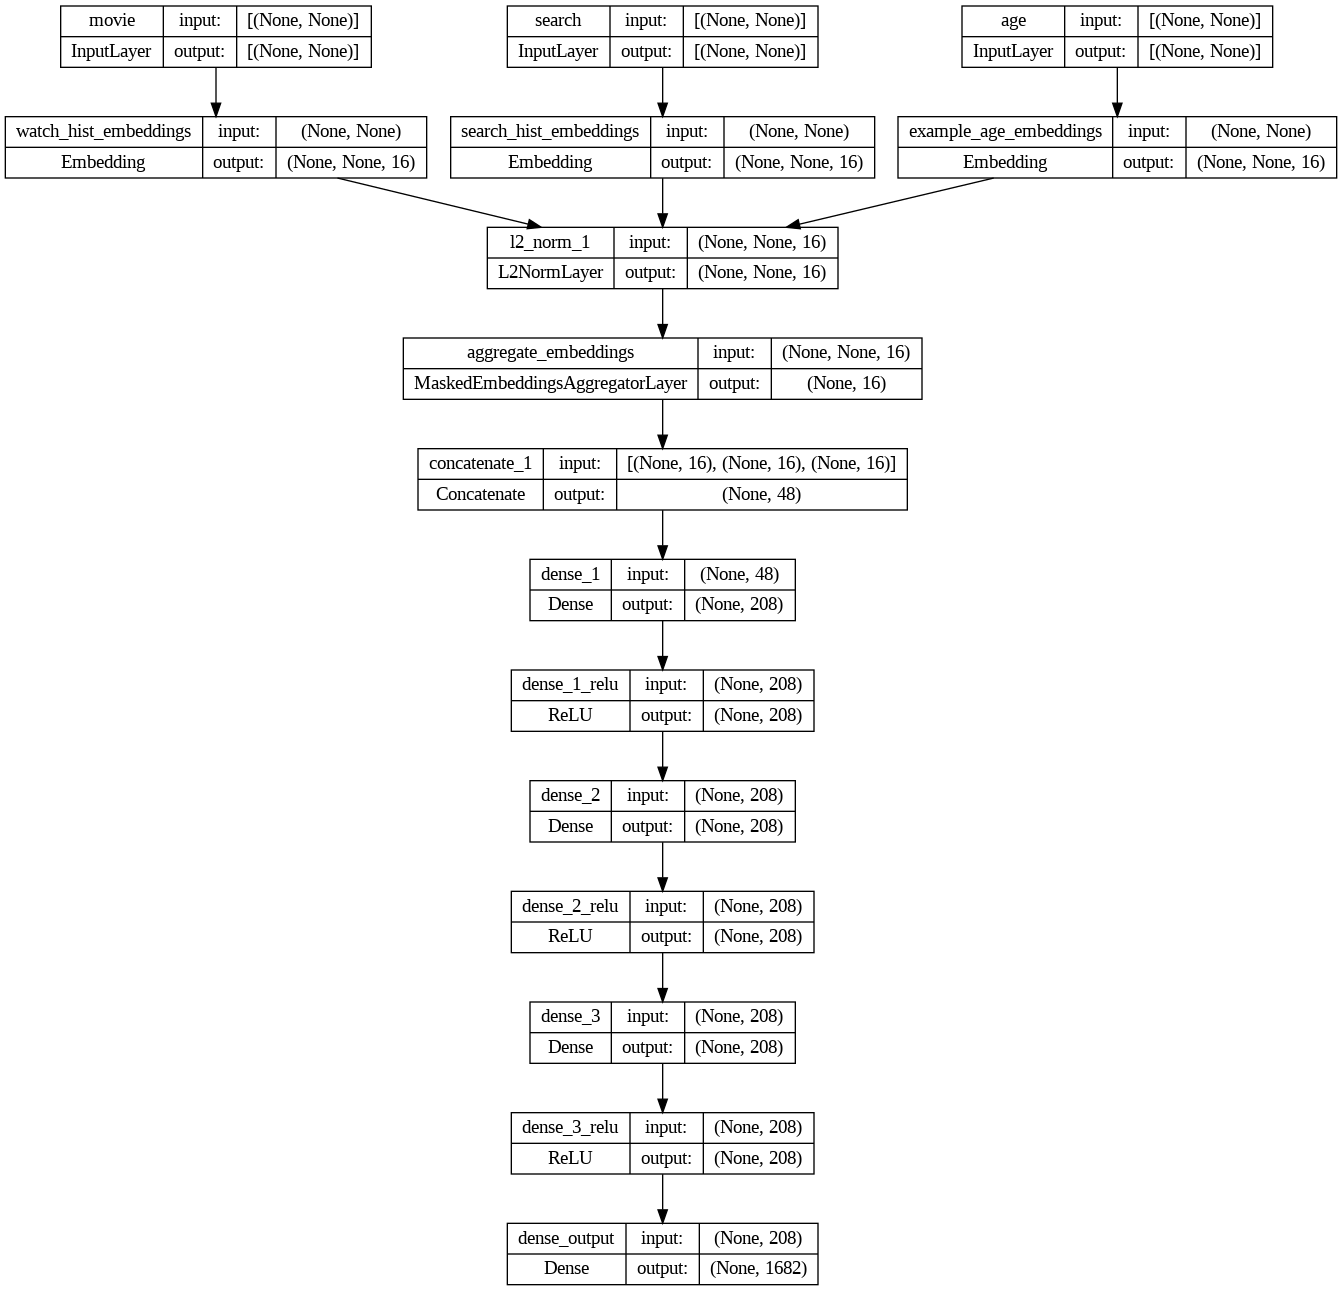

In [19]:
tf.keras.utils.plot_model(candidate_generation.model_cg, show_shapes=True, show_layer_names=True,dpi=96)


In [20]:

trainset_r = dataset.dataset_ranking
x_r, y_r = {"movie_name": tf.keras.preprocessing.sequence.pad_sequences(trainset_r['title_d'], padding='post'),
          "like": tf.keras.preprocessing.sequence.pad_sequences(trainset_r['like'], padding='post'),
          "dislike": tf.keras.preprocessing.sequence.pad_sequences(trainset_r['dislike'], padding='post'),
          "genre": tf.keras.preprocessing.sequence.pad_sequences(trainset_r['all_genres'], padding='post'),
          "candidate": tf.keras.preprocessing.sequence.pad_sequences(trainset_r['candidate'], padding='post'),
}, trainset_r['predict_labels']


# split ranking data into train, validation, and test indices
x_train_r = {key: value[train_indices] for key, value in x_r.items()}
y_train_r = y_r.iloc[train_indices]
x_val_r = {key: value[val_indices] for key, value in x_r.items()}
y_val_r = y_r.iloc[val_indices]
x_test_r = {key: value[test_indices] for key, value in x_r.items()}
y_test_r = y_r.iloc[test_indices]

In [21]:
import tensorflow as tf
import numpy as np

class RankingTrain():
  def __init__(self):
    pass

  def hyper_search(self):
    self.tuner = kt.Hyperband(Ranking,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyper_params',
    project_name='r_hyperband')
    # Early stopping set after 10 epochs
    self.stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    self.tuner.search(x_train_r, y_train_r, epochs=10, validation_data=(x_val_r, y_val_r), callbacks=[self.stop_early])

  def build_model(self):
    best_hps = self.tuner.get_best_hyperparameters()[0]
    self.model_r = self.tuner.hypermodel.build(best_hps)

  def re_train(self):
    # Train the hypertuned model
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history_r = self.model_r.fit(x_train_r, y_train_r, batch_size=4, epochs=50, validation_data=(x_val_r, y_val_r), callbacks=[stop_early])
    anchor_loss['loss'] = history_r.history['loss']
    anchor_loss['val_loss'] = history_r.history['val_loss']
    anchor_acc['acc'] = history_r.history['acc']
    anchor_acc['val_acc'] = history_r.history['val_acc']
    self.pred = self.model_r.predict(x_test_r)
    self.label = y_test_r.copy()


In [22]:
ranking = RankingTrain()
ranking.hyper_search()
ranking.build_model()
ranking.re_train()

Trial 30 Complete [00h 00m 14s]
val_loss: 7.073265552520752

Best val_loss So Far: 7.056163787841797
Total elapsed time: 00h 04m 06s
Epoch 1/50
165/165 [==============================] - 6s 18ms/step - loss: 7.2252 - acc: 0.0015 - val_loss: 7.0911 - val_acc: 0.0000e+00
Epoch 2/50
165/165 [==============================] - 4s 25ms/step - loss: 6.1937 - acc: 0.0152 - val_loss: 7.2181 - val_acc: 0.0000e+00
Epoch 3/50
165/165 [==============================] - 2s 13ms/step - loss: 5.8507 - acc: 0.0091 - val_loss: 7.6795 - val_acc: 0.0071
Epoch 4/50
165/165 [==============================] - 2s 13ms/step - loss: 5.6100 - acc: 0.0121 - val_loss: 8.3128 - val_acc: 0.0000e+00
Epoch 5/50
165/165 [==============================] - 2s 13ms/step - loss: 5.3922 - acc: 0.0152 - val_loss: 8.6179 - val_acc: 0.0071
Epoch 6/50
165/165 [==============================] - 2s 13ms/step - loss: 5.2410 - acc: 0.0197 - val_loss: 8.6938 - val_acc: 0.0142
Epoch 7/50
165/165 [==============================] - 3s 

In [23]:
best_hps = ranking.tuner.get_best_hyperparameters()[0]
print(f"best number of hidden units: {best_hps.get('hidden_units')}, best number of learning rate: {best_hps.get('learning_rate')}")

best number of hidden units: 176, best number of learning rate: 0.01


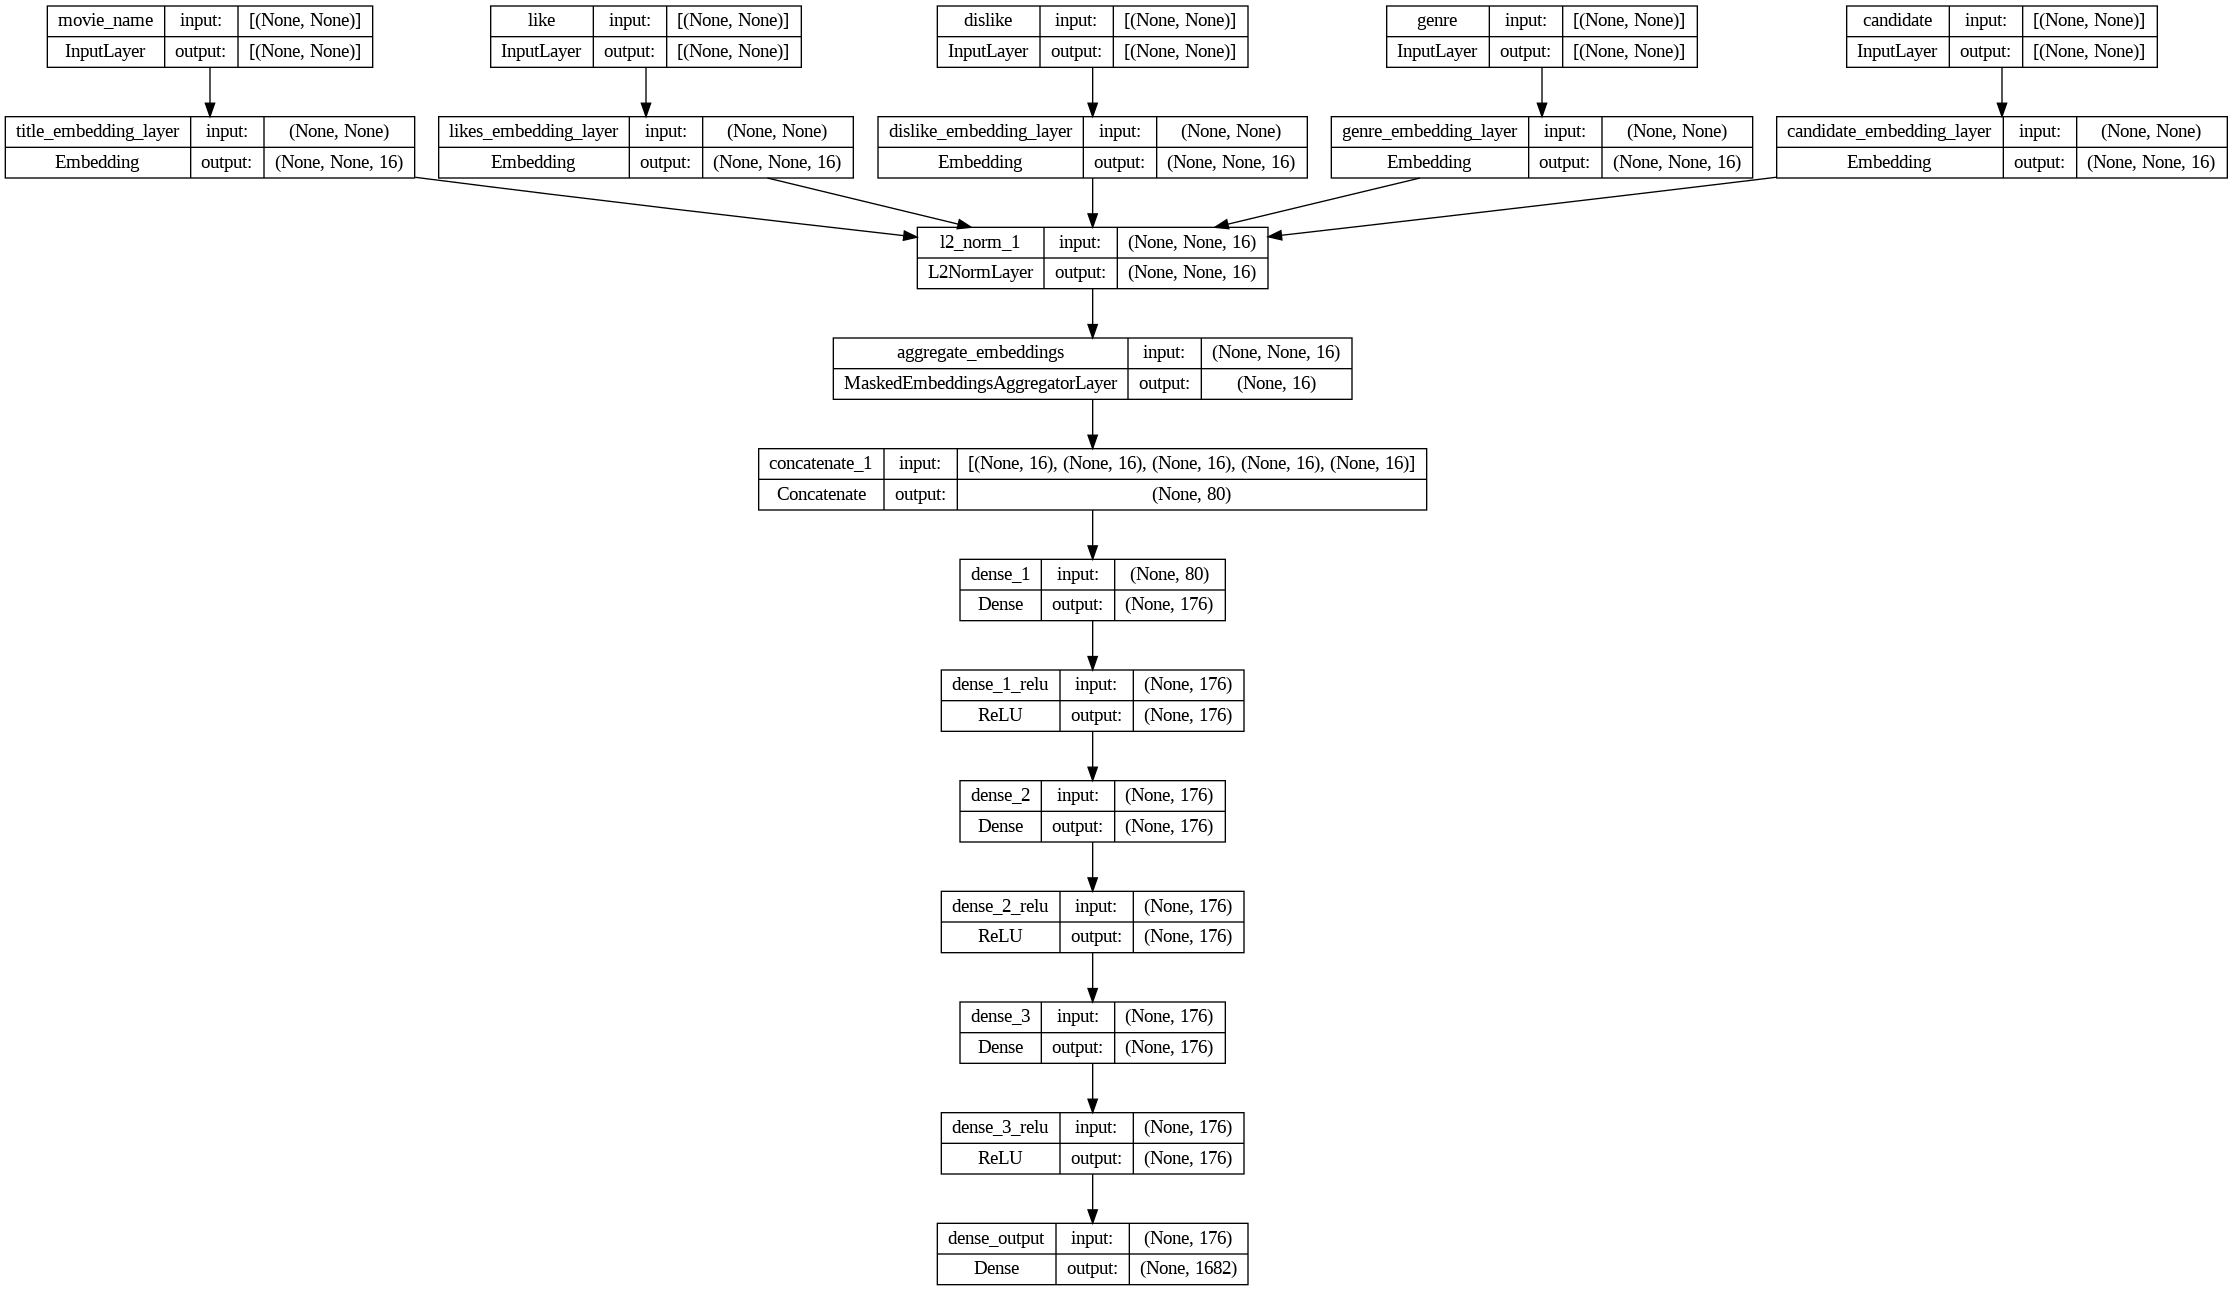

In [24]:
tf.keras.utils.plot_model(ranking.model_r, show_shapes=True, show_layer_names=True,dpi=96)


### Execute ranking with dropout

In [25]:
import tensorflow as tf
import numpy as np

class Dropout_RankingTrain():
  def __init__(self):
    pass

  def hyper_search(self):
    self.tuner = kt.Hyperband(Ranking_improved,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyper_params',
    project_name='r_hyperband')
    # Early stopping set after 10 epochs
    self.stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    self.tuner.search(x_train_r, y_train_r, epochs=10, validation_data=(x_val_r, y_val_r), callbacks=[self.stop_early])

  def build_model(self):
    best_hps = self.tuner.get_best_hyperparameters()[0]
    self.model_r = self.tuner.hypermodel.build(best_hps)

  def re_train(self):
    # Train the hypertuned model
    self.predictions = []
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history_r = self.model_r.fit(x_train_r, y_train_r, batch_size=4, epochs=50, validation_data=(x_val_r, y_val_r), callbacks=[stop_early])
    dropout_loss['loss'] = history_r.history['loss']
    dropout_loss['val_loss'] = history_r.history['val_loss']
    dropout_acc['acc'] = history_r.history['acc']
    dropout_acc['val_acc'] = history_r.history['val_acc']
    self.pred = self.model_r.predict(x_test_r)
    self.label = y_test_r.copy()


In [26]:
dropout_ranking = Dropout_RankingTrain()
dropout_ranking.hyper_search()
dropout_ranking.build_model()
dropout_ranking.re_train()

Epoch 1/50
165/165 [==============================] - 7s 16ms/step - loss: 7.2543 - acc: 0.0030 - val_loss: 7.0896 - val_acc: 0.0142
Epoch 2/50
165/165 [==============================] - 2s 13ms/step - loss: 6.3396 - acc: 0.0091 - val_loss: 7.1711 - val_acc: 0.0000e+00
Epoch 3/50
165/165 [==============================] - 2s 13ms/step - loss: 6.0060 - acc: 0.0121 - val_loss: 7.3731 - val_acc: 0.0000e+00
Epoch 4/50
165/165 [==============================] - 3s 17ms/step - loss: 5.9182 - acc: 0.0091 - val_loss: 7.9210 - val_acc: 0.0000e+00
Epoch 5/50
165/165 [==============================] - 3s 21ms/step - loss: 5.7735 - acc: 0.0121 - val_loss: 7.7577 - val_acc: 0.0000e+00
Epoch 6/50
165/165 [==============================] - 2s 14ms/step - loss: 5.7641 - acc: 0.0091 - val_loss: 7.9194 - val_acc: 0.0000e+00
Epoch 7/50
165/165 [==============================] - 2s 15ms/step - loss: 5.7273 - acc: 0.0076 - val_loss: 8.6974 - val_acc: 0.0000e+00
Epoch 8/50
165/165 [=========================

In [27]:
best_hps = dropout_ranking.tuner.get_best_hyperparameters()[0]
print(f"best number of hidden units: {best_hps.get('hidden_units')}, best number of learning rate: {best_hps.get('learning_rate')}")

best number of hidden units: 176, best number of learning rate: 0.01


### Execute improvment model

In [28]:
import tensorflow as tf
import numpy as np

class Monte_Carlo_RankingTrain():
  def __init__(self):
    pass

  def hyper_search(self):
    self.tuner = kt.Hyperband(Ranking_improved,
    objective='val_loss',
    max_epochs=10,
    factor=3,
    directory='hyper_params',
    project_name='r_hyperband')
    # Early stopping set after 10 epochs
    self.stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    self.tuner.search(x_train_r, y_train_r, epochs=10, validation_data=(x_val_r, y_val_r), callbacks=[self.stop_early])

  def build_model(self):
    best_hps = self.tuner.get_best_hyperparameters()[0]
    self.model_r = self.tuner.hypermodel.build(best_hps)

  def re_train(self):
    # Train the hypertuned model
    self.predictions = []
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    history_r = self.model_r.fit(x_train_r, y_train_r, batch_size=4, epochs=50, validation_data=(x_val_r, y_val_r), callbacks=[stop_early])
    monte_carlo_loss['loss'] = history_r.history['loss']
    monte_carlo_loss['val_loss'] = history_r.history['val_loss']
    monte_carlo_acc['acc'] = history_r.history['acc']
    monte_carlo_acc['val_acc'] = history_r.history['val_acc']
    for i in range(50):
      self.predictions.append(self.model_r.predict(x_test_r))
    tensor = tf.convert_to_tensor(self.predictions)
    mean_tensor = tf.reduce_mean(tensor, axis=0)
    std_tensor = tf.math.reduce_std(tensor, axis=0)
    predictions_pi = tfp.distributions.Normal(mean_tensor, std_tensor)
    self.pred = np.squeeze(predictions_pi.sample(1).numpy())
    self.label = y_test_r.copy()


In [29]:
monte_carlo_ranking = Monte_Carlo_RankingTrain()
monte_carlo_ranking.hyper_search()
monte_carlo_ranking.build_model()
monte_carlo_ranking.re_train()

Epoch 1/50
165/165 [==============================] - 6s 16ms/step - loss: 7.2546 - acc: 0.0015 - val_loss: 7.0501 - val_acc: 0.0142
Epoch 2/50
165/165 [==============================] - 3s 20ms/step - loss: 6.2997 - acc: 0.0091 - val_loss: 7.2717 - val_acc: 0.0071
Epoch 3/50
165/165 [==============================] - 3s 16ms/step - loss: 6.1078 - acc: 0.0045 - val_loss: 7.3053 - val_acc: 0.0071
Epoch 4/50
165/165 [==============================] - 2s 13ms/step - loss: 5.8576 - acc: 0.0121 - val_loss: 7.6229 - val_acc: 0.0071
Epoch 5/50
165/165 [==============================] - 2s 13ms/step - loss: 5.8468 - acc: 0.0152 - val_loss: 7.8479 - val_acc: 0.0071
Epoch 6/50
165/165 [==============================] - 2s 15ms/step - loss: 5.7183 - acc: 0.0152 - val_loss: 8.2022 - val_acc: 0.0000e+00
Epoch 7/50
165/165 [==============================] - 3s 18ms/step - loss: 5.6807 - acc: 0.0121 - val_loss: 8.4501 - val_acc: 0.0000e+00
Epoch 8/50
165/165 [==============================] - 3s 16ms

In [30]:
best_hps = monte_carlo_ranking.tuner.get_best_hyperparameters()[0]
print(f"best number of hidden units: {best_hps.get('hidden_units')}, best number of learning rate: {best_hps.get('learning_rate')}")

best number of hidden units: 176, best number of learning rate: 0.01


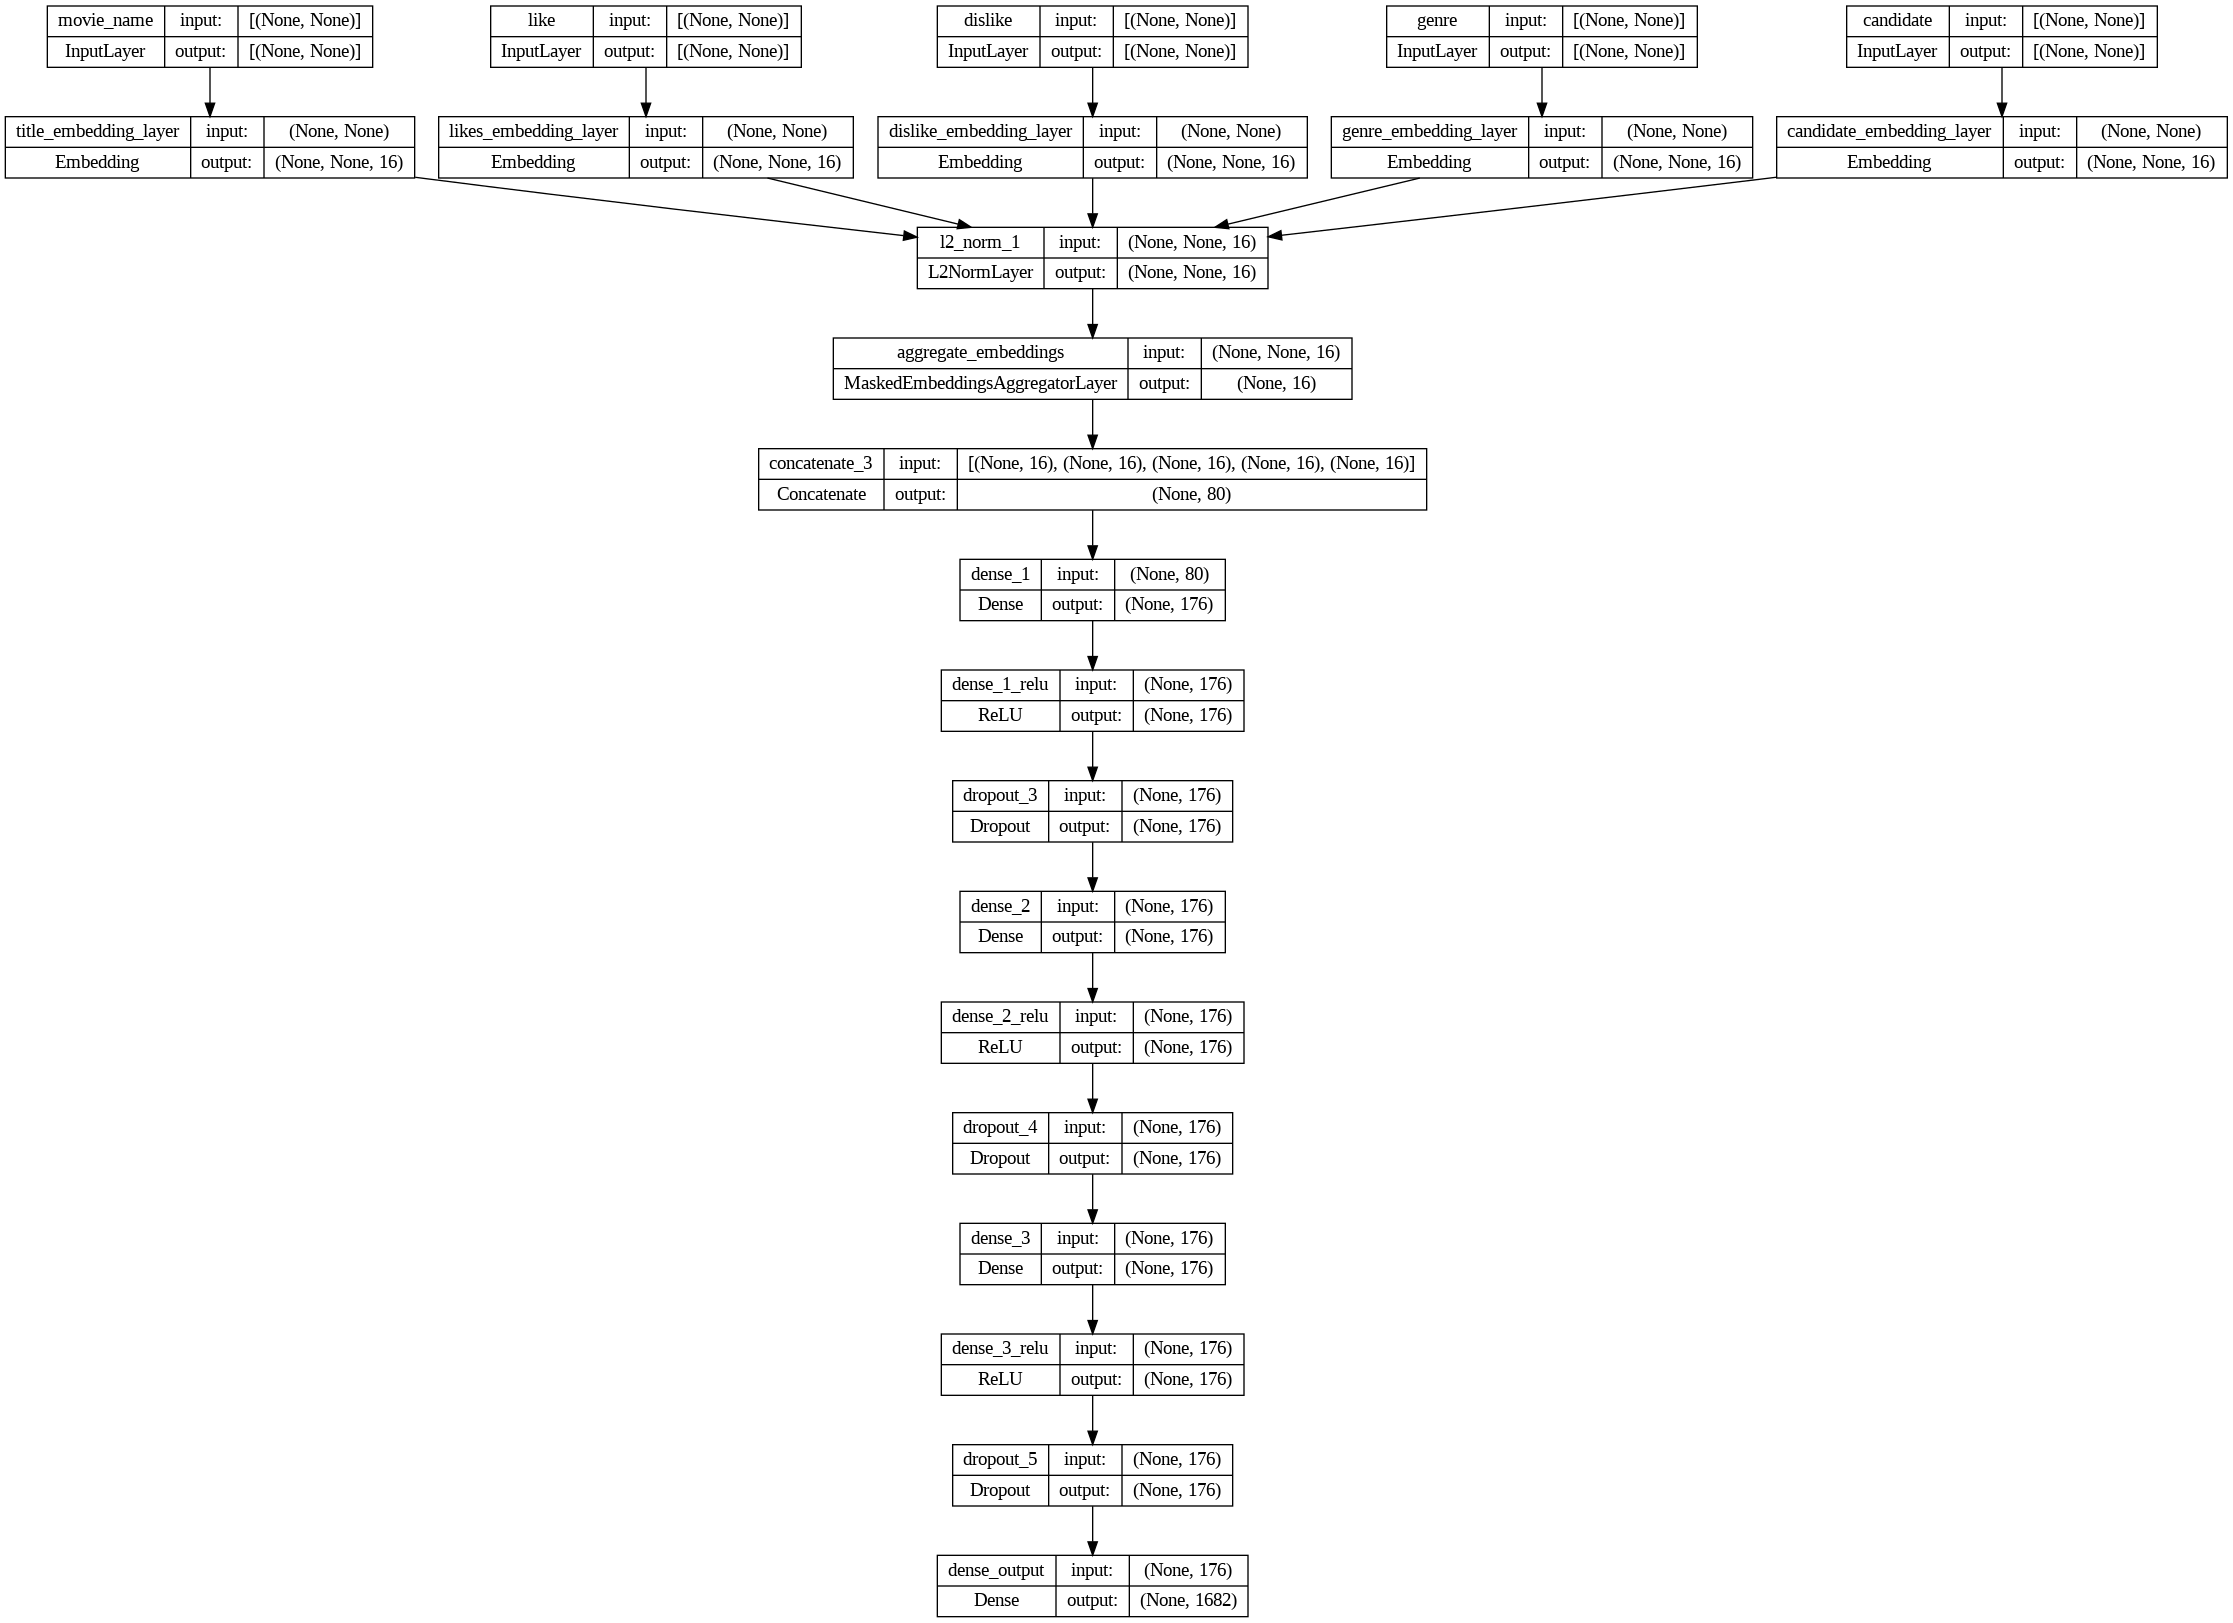

In [31]:
tf.keras.utils.plot_model(monte_carlo_ranking.model_r, show_shapes=True, show_layer_names=True,dpi=96)


### Implementaion and exeecution of a well-known algorithm for comparison

Glocal_K

In [32]:
def load_data2():

    train_set = np.loadtxt('ml-100k/u1.base', skiprows=0, delimiter='\t').astype('int32')
    test_set = np.loadtxt('ml-100k/u1.test', skiprows=0, delimiter='\t').astype('int32')
    all_data = np.concatenate((train_set, test_set), axis=0)

    users = np.unique(all_data[:,0]).size
    movies = np.unique(all_data[:,1]).size
    print('users:', users)
    print('movies:', movies)

    # training ratings
    training_ratings = train_set.shape[0]
    train_r = np.zeros((movies, users), dtype='float32')

    for i in range(training_ratings):
        train_r[train_set[i,1]-1, train_set[i,0]-1] = train_set[i,2]

    train_mask = np.greater(train_r, 1e-12).astype('float32')
    print('training ratings:',training_ratings)

    # test ratings
    test_ratings = test_set.shape[0]
    test_r = np.zeros((movies, users), dtype='float32')

    for i in range(test_ratings):
        test_r[test_set[i,1]-1, test_set[i,0]-1] = test_set[i,2]

    test_mask = np.greater(test_r, 1e-12).astype('float32')
    print('num of test ratings:', test_ratings)

    return users, movies, train_r, train_mask, test_r, test_mask

In [33]:
users, movies, train_r, train_mask, test_r, test_mask = load_data2()

users: 943
movies: 1682
training ratings: 80000
num of test ratings: 20000


In [34]:
hidden_layers_size = 500
hidden_layers_number = 2
n_dim = 5
glocal_k_size = 3

max_epoch_pretraining = 500 
max_epoch_finetuning = 1000
patience_before_pretraining = 5
patience_before_finetuning = 10 
tol_p = 1e-4 # minimum threshold for the difference between consecutive values of train rmse, used for early stopping, for pretraining
tol_f = 1e-5 # and finetuning
lambda_2 = 20. # regularisation of number or parameters
lambda_s = 0.006 # regularisation of sparsity of the final matrix
dot_scale = 1 # dot product weight for global kernel

In [35]:
def local_kernel(u, v):
    dist = torch.norm(u - v, p=2, dim=2)
    hat = torch.clamp(1. - dist**2, min=0.)
    return hat

class KernelLayer(nn.Module):
    def __init__(self, n_in, n_hid, n_dim, lambda_s, lambda_2, activation=nn.Sigmoid()):
      super().__init__()
      self.W = nn.Parameter(torch.randn(n_in, n_hid))
      self.u = nn.Parameter(torch.randn(n_in, 1, n_dim))
      self.v = nn.Parameter(torch.randn(1, n_hid, n_dim))
      self.b = nn.Parameter(torch.randn(n_hid))

      self.lambda_s = lambda_s
      self.lambda_2 = lambda_2

      nn.init.xavier_uniform_(self.W, gain=torch.nn.init.calculate_gain("relu"))
      nn.init.xavier_uniform_(self.u, gain=torch.nn.init.calculate_gain("relu"))
      nn.init.xavier_uniform_(self.v, gain=torch.nn.init.calculate_gain("relu"))
      nn.init.zeros_(self.b)
      self.activation = activation

    def forward(self, x):
      w_hat = local_kernel(self.u, self.v)
    
      sparse_reg = torch.nn.functional.mse_loss(w_hat, torch.zeros_like(w_hat))
      sparse_reg_term = self.lambda_s * sparse_reg
      
      l2_reg = torch.nn.functional.mse_loss(self.W, torch.zeros_like(self.W))
      l2_reg_term = self.lambda_2 * l2_reg

      W_eff = self.W * w_hat  # Local kernelised weight matrix
      y = torch.matmul(x, W_eff) + self.b
      y = self.activation(y)

      return y, sparse_reg_term + l2_reg_term

class KernelNet(nn.Module):
    def __init__(self, n_u, n_hid, n_dim, n_layers, lambda_s, lambda_2):
      super().__init__()
      layers = []
      for i in range(n_layers):
        if i == 0:
          layers.append(KernelLayer(n_u, n_hid, n_dim, lambda_s, lambda_2))
        else:
          layers.append(KernelLayer(n_hid, n_hid, n_dim, lambda_s, lambda_2))
      layers.append(KernelLayer(n_hid, n_u, n_dim, lambda_s, lambda_2, activation=nn.Identity()))
      self.layers = nn.ModuleList(layers)
      self.dropout = nn.Dropout(0.33)

    def forward(self, x):
      total_reg = None
      for i, layer in enumerate(self.layers):
        x, reg = layer(x)
        if i < len(self.layers)-1:
          x = self.dropout(x)
        if total_reg is None:
          total_reg = reg
        else:
          total_reg += reg
      return x, total_reg

In [36]:
class CompleteNet(nn.Module):
    def __init__(self, kernel_net, n_u, n_m, n_hid, n_dim, n_layers, lambda_s, lambda_2, gk_size, dot_scale):
      super().__init__()
      self.gk_size = gk_size
      self.dot_scale = dot_scale
      self.local_kernel_net = kernel_net
      self.conv_kernel = torch.nn.Parameter(torch.randn(n_m, gk_size**2) * 0.1)
      nn.init.xavier_uniform_(self.conv_kernel, gain=torch.nn.init.calculate_gain("relu"))
      

    def forward(self, x, x_local):
      gk = self.global_kernel(x_local, self.gk_size, self.dot_scale)
      x = self.global_conv(x, gk)
      x, global_reg_loss = self.local_kernel_net(x)
      return x, global_reg_loss

    def global_kernel(self, input, gk_size, dot_scale):
      avg_pooling = torch.mean(input, dim=1)  # Item (axis=1) based average pooling
      avg_pooling = avg_pooling.view(1, -1)

      gk = torch.matmul(avg_pooling, self.conv_kernel) * dot_scale  # Scaled dot product
      gk = gk.view(1, 1, gk_size, gk_size)

      return gk

    def global_conv(self, input, W):
      input = input.unsqueeze(0).unsqueeze(0)
      conv2d = nn.LeakyReLU()(F.conv2d(input, W, stride=1, padding=1))
      return conv2d.squeeze(0).squeeze(0)

class Loss(nn.Module):
    def forward(self, pred_p, reg_loss, train_mask, train_r):
      # L2 loss
      diff = train_mask * (train_r - pred_p)
      sqE = torch.nn.functional.mse_loss(diff, torch.zeros_like(diff))
      loss_p = sqE + reg_loss
      return loss_p

In [37]:
model = KernelNet(users, hidden_layers_size, n_dim, hidden_layers_number, lambda_s, lambda_2).double().to(device)

In [38]:
complete_model = CompleteNet(model, users, movies, hidden_layers_size, n_dim, hidden_layers_number, lambda_s, lambda_2, glocal_k_size, dot_scale).double().to(device)

In [39]:
def dcg_k(score_label, k):
    dcg, i = 0., 0
    for s in score_label:
        if i < k:
            dcg += (2**s[1]-1) / np.log2(2+i)
            i += 1
    return dcg
    
def ndcg_k(y_hat, y, k):
    score_label = np.stack([y_hat, y], axis=1).tolist()
    score_label = sorted(score_label, key=lambda d:d[0], reverse=True)
    score_label_ = sorted(score_label, key=lambda d:d[1], reverse=True)
    norm, i = 0., 0
    for s in score_label_:
        if i < k:
            norm += (2**s[1]-1) / np.log2(2+i)
            i += 1
    dcg = dcg_k(score_label, k)
    return dcg / norm

def call_ndcg(y_hat, y):
    ndcg_sum, num = 0, 0
    y_hat, y = y_hat.T, y.T
    n_users = y.shape[0]

    for i in range(n_users):
        y_hat_i = y_hat[i][np.where(y[i])]
        y_i = y[i][np.where(y[i])]

        if y_i.shape[0] < 2:
            continue

        ndcg_sum += ndcg_k(y_hat_i, y_i, y_i.shape[0])  # user-wise calculation
        num += 1

    return ndcg_sum / num

pre training

In [40]:
best_rmse_epoch, best_rmse_result, last_rmse = 0, float("inf"), np.inf
best_mae_epoch, best_mae_result = 0, float("inf")
best_ndcg_epoch, best_ndcg_result = 0, 0

optimizer = torch.optim.AdamW(complete_model.local_kernel_net.parameters(), lr=0.001)
time_cumulative, tic = 0, time()
counter = 0

In [41]:
def closure():
  optimizer.zero_grad()
  r = torch.Tensor(train_r).double().to(device)
  m = torch.Tensor(train_mask).double().to(device)
  complete_model.local_kernel_net.train()
  pred, reg = complete_model.local_kernel_net(r)
  loss = Loss().to(device)(pred, reg, m, r)
  loss.backward()
  return loss

In [42]:
for i in range(max_epoch_pretraining):
  optimizer.step(closure)
  complete_model.local_kernel_net.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = model(torch.Tensor(train_r).double().to(device))
  pre = pre.float().cpu().detach().numpy()
  
  error = (test_mask * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_mask.sum()
  test_rmse = np.sqrt(error)

  error_train = (train_mask * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_mask.sum()
  train_rmse = np.sqrt(error_train)

  counter = counter + 1 if last_rmse - train_rmse < tol_p else 0

  last_rmse = train_rmse

  if patience_before_pretraining == counter:
    print('Epoch:', i+1, '\ntest rmse:', test_rmse, '\ntrain rmse:', train_rmse, '\nTime:', t, 's', '\nTime cumulative:', time_cumulative, 's\n\n')
    break

  if i % 50 != 0:
    continue
  print('Epoch:', i, '\ntest rmse:', test_rmse, '\ntrain rmse:', train_rmse, '\nTime:', t, 's', '\nTime cumulative:', time_cumulative, 's\n\n')

print('done')

Epoch: 0 
test rmse: 2.7627025 
train rmse: 2.7346532 
Time: 2.1286940574645996 s 
Time cumulative: 2.1286940574645996 s


Epoch: 50 
test rmse: 1.0238451 
train rmse: 0.987369 
Time: 74.73257613182068 s 
Time cumulative: 1945.9946792125702 s


Epoch: 100 
test rmse: 0.96305656 
train rmse: 0.9198829 
Time: 146.19735860824585 s 
Time cumulative: 7560.564524888992 s


Epoch: 139 
test rmse: 0.95724773 
train rmse: 0.91400504 
Time: 198.9380977153778 s 
Time cumulative: 14164.982991933823 s


done


fine tuning

In [43]:
train_r_local = np.clip(pre, 1., 5.)
last_rmse = np.inf
optimizer = torch.optim.AdamW(complete_model.parameters(), lr=0.001)
counter = 0

In [44]:
def closure():
  optimizer.zero_grad()
  x = torch.Tensor(train_r).double().to(device)
  x_local = torch.Tensor(train_r_local).double().to(device)
  m = torch.Tensor(train_mask).double().to(device)
  complete_model.train()
  pred, reg = complete_model(x, x_local)
  loss = Loss().to(device)(pred, reg, m, x)
  loss.backward()
  return loss

In [45]:
for i in range(max_epoch_finetuning):
  optimizer.step(closure)
  complete_model.eval()
  t = time() - tic
  time_cumulative += t

  pre, _ = complete_model(torch.Tensor(train_r).double().to(device), torch.Tensor(train_r_local).double().to(device))
  pre = pre.float().cpu().detach().numpy()

  error = (test_mask * (np.clip(pre, 1., 5.) - test_r) ** 2).sum() / test_mask.sum()
  test_rmse = np.sqrt(error)

  error_train = (train_mask * (np.clip(pre, 1., 5.) - train_r) ** 2).sum() / train_mask.sum()
  train_rmse = np.sqrt(error_train)

  test_mae = (test_mask * np.abs(np.clip(pre, 1., 5.) - test_r)).sum() / test_mask.sum()
  train_mae = (train_mask * np.abs(np.clip(pre, 1., 5.) - train_r)).sum() / train_mask.sum()

  test_ndcg = call_ndcg(np.clip(pre, 1., 5.), test_r)
  train_ndcg = call_ndcg(np.clip(pre, 1., 5.), train_r)

  best_rmse_result, best_rmse_epoch = (test_rmse, i+1) if test_rmse < best_rmse_result else (best_rmse_result, best_rmse_epoch)
  best_mae_result, best_mae_epoch = (test_mae, i+1) if test_mae < best_mae_result else (best_mae_result, best_mae_epoch)
  best_ndcg_result, best_ndcg_epoch = (test_ndcg, i+1) if best_ndcg_result < test_ndcg else (best_ndcg_result, best_ndcg_epoch)

  counter = counter + 1 if last_rmse - train_rmse < tol_f else 0

  last_rmse = train_rmse

  if patience_before_finetuning == counter:
    print('Epoch:', i+1, '\ntest rmse:', test_rmse, '\ntest mae:', test_mae, '\ntest ndcg:', test_ndcg, '\ntrain rmse:', train_rmse, '\ntrain mae:', train_mae, '\ntrain ndcg:', train_ndcg, 
        '\nTime:', t, 's', '\nTime cumulative:', time_cumulative, 's\n\n')  
    break

  if i % 100 != 0:
    continue

  print('Epoch:', i, '\ntest rmse:', test_rmse, '\ntest mae:', test_mae, '\ntest ndcg:', test_ndcg, '\ntrain rmse:', train_rmse, '\ntrain mae:', train_mae, '\ntrain ndcg:', train_ndcg, 
        '\nTime:', t, 's', '\nTime cumulative:', time_cumulative, 's\n\n')
  
print('done')


Epoch: 0 
test rmse: 1.0316205 
test mae: 0.83973694 
test ndcg: 0.8810017400615364 
train rmse: 0.9930784 
train mae: 0.8113726 
train ndcg: 0.8866179248282934 
Time: 201.26693415641785 s 
Time cumulative: 14366.24992609024 s


Epoch: 100 
test rmse: 0.9117558 
test mae: 0.72003055 
test ndcg: 0.8993061216038469 
train rmse: 0.8493895 
train mae: 0.67129725 
train ndcg: 0.9083757837419215 
Time: 457.2150716781616 s 
Time cumulative: 47275.48010587692 s


Epoch: 200 
test rmse: 0.908177 
test mae: 0.7159984 
test ndcg: 0.899617072666223 
train rmse: 0.8417903 
train mae: 0.66426885 
train ndcg: 0.9107576301240669 
Time: 707.1172411441803 s 
Time cumulative: 105640.82716083527 s


Epoch: 300 
test rmse: 0.90800506 
test mae: 0.7168434 
test ndcg: 0.8972925162551763 
train rmse: 0.83960944 
train mae: 0.66362965 
train ndcg: 0.912760077032674 
Time: 956.034375667572 s 
Time cumulative: 189016.25181651115 s


Epoch: 400 
test rmse: 0.9086498 
test mae: 0.7160593 
test ndcg: 0.898535964054

In [46]:
# Final result
print('Epoch:', best_rmse_epoch, ' best rmse:', best_rmse_result)
print('Epoch:', best_mae_epoch, ' best mae:', best_mae_result)
print('Epoch:', best_ndcg_epoch, ' best ndcg:', best_ndcg_result)

Epoch: 887  best rmse: 0.9058916
Epoch: 966  best mae: 0.7128238
Epoch: 204  best ndcg: 0.900631663508036


## Analytics

### Loss & Accuracy

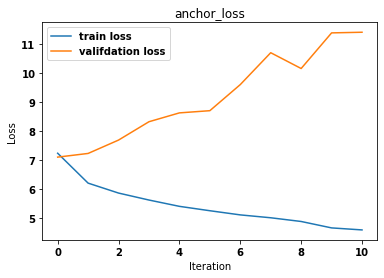

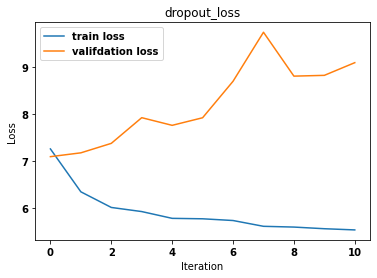

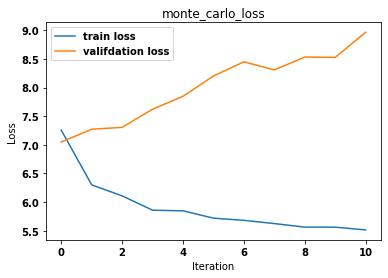

In [47]:
# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)


for model in losses:
    plt.plot(losses[model]['loss'],label="train loss")
    plt.plot(losses[model]['val_loss'] ,label="valifdation loss")
    plt.title(model)
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

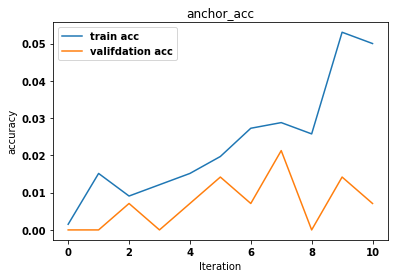

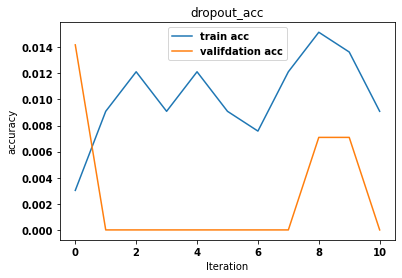

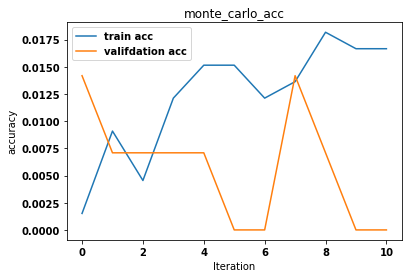

In [48]:
for model in accuracy:
    plt.plot(accuracy[model]['acc'],label="train acc")
    plt.plot(accuracy[model]['val_acc'] ,label="valifdation acc")
    plt.title(model)
    plt.xlabel("Iteration")
    plt.ylabel("accuracy")
    plt.legend()
    plt.show()
    # break

### metrics

In [49]:
import math

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0
  
def getMRR(ranklist, gtItem):
    num_movies_tested = 0
    for item in ranklist:
        num_movies_tested += 1
        if item == gtItem:
            mrr = 1 / num_movies_tested
            return mrr
    return 0

In [50]:
results = pd.DataFrame(columns = ['model', 'topk','metric','score']) # as suggested to us
results

,model,topk,metric,score


In [51]:
def evaluate_model(model_name, y_pred, labels, results):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    for k in [5, 10]:
      hits, ndcgs, mrrs = [],[],[]
      top_k = np.argsort(-y_pred, axis=1)[:, :k]
      for idx in range(len(top_k)):   
        hr = getHitRatio(top_k[idx], labels[idx])
        ndcg = getNDCG(top_k[idx], labels[idx])
        mrr = getMRR(top_k[idx], labels[idx])
        hits.append(hr)
        ndcgs.append(ndcg)  
        mrrs.append(mrr)
      results.loc[-1] = [model_name ,k,'HR',np.mean(hits)] ;results.reset_index(drop = True,inplace = True)
      results.loc[-1] = [model_name ,k,'NDCG',np.mean(ndcgs)] ;results.reset_index(drop = True,inplace = True)
      results.loc[-1] = [model_name ,k,'MRR',np.mean(mrrs)] ;results.reset_index(drop = True,inplace = True)

In [63]:
evaluate_model("anchor_model", ranking.pred, ranking.label.values, results)

In [53]:
evaluate_model("dropout_model", dropout_ranking.pred, dropout_ranking.label.values, results)


In [54]:
evaluate_model("monte_carlo_model", monte_carlo_ranking.pred, monte_carlo_ranking.label.values, results)


In [59]:
# evaluate_model("GLocal-K", glocal_k.pred, glocal_k.label.values, results)
# results.loc[-1] = ["GLocal",5,'NDCG',best_ndcg_result] ;results.reset_index(drop = True,inplace = True)

In [ ]:
results

,model,topk,metric,score
0,anchor_model,5,HR,0.021127
1,anchor_model,5,NDCG,0.021127
2,anchor_model,5,MRR,0.021127
3,anchor_model,10,HR,0.021127
4,anchor_model,10,NDCG,0.021127
5,anchor_model,10,MRR,0.021127
6,dropout_model,5,HR,0.021127
7,dropout_model,5,NDCG,0.015007
8,dropout_model,5,MRR,0.012911
9,dropout_model,10,HR,0.042254


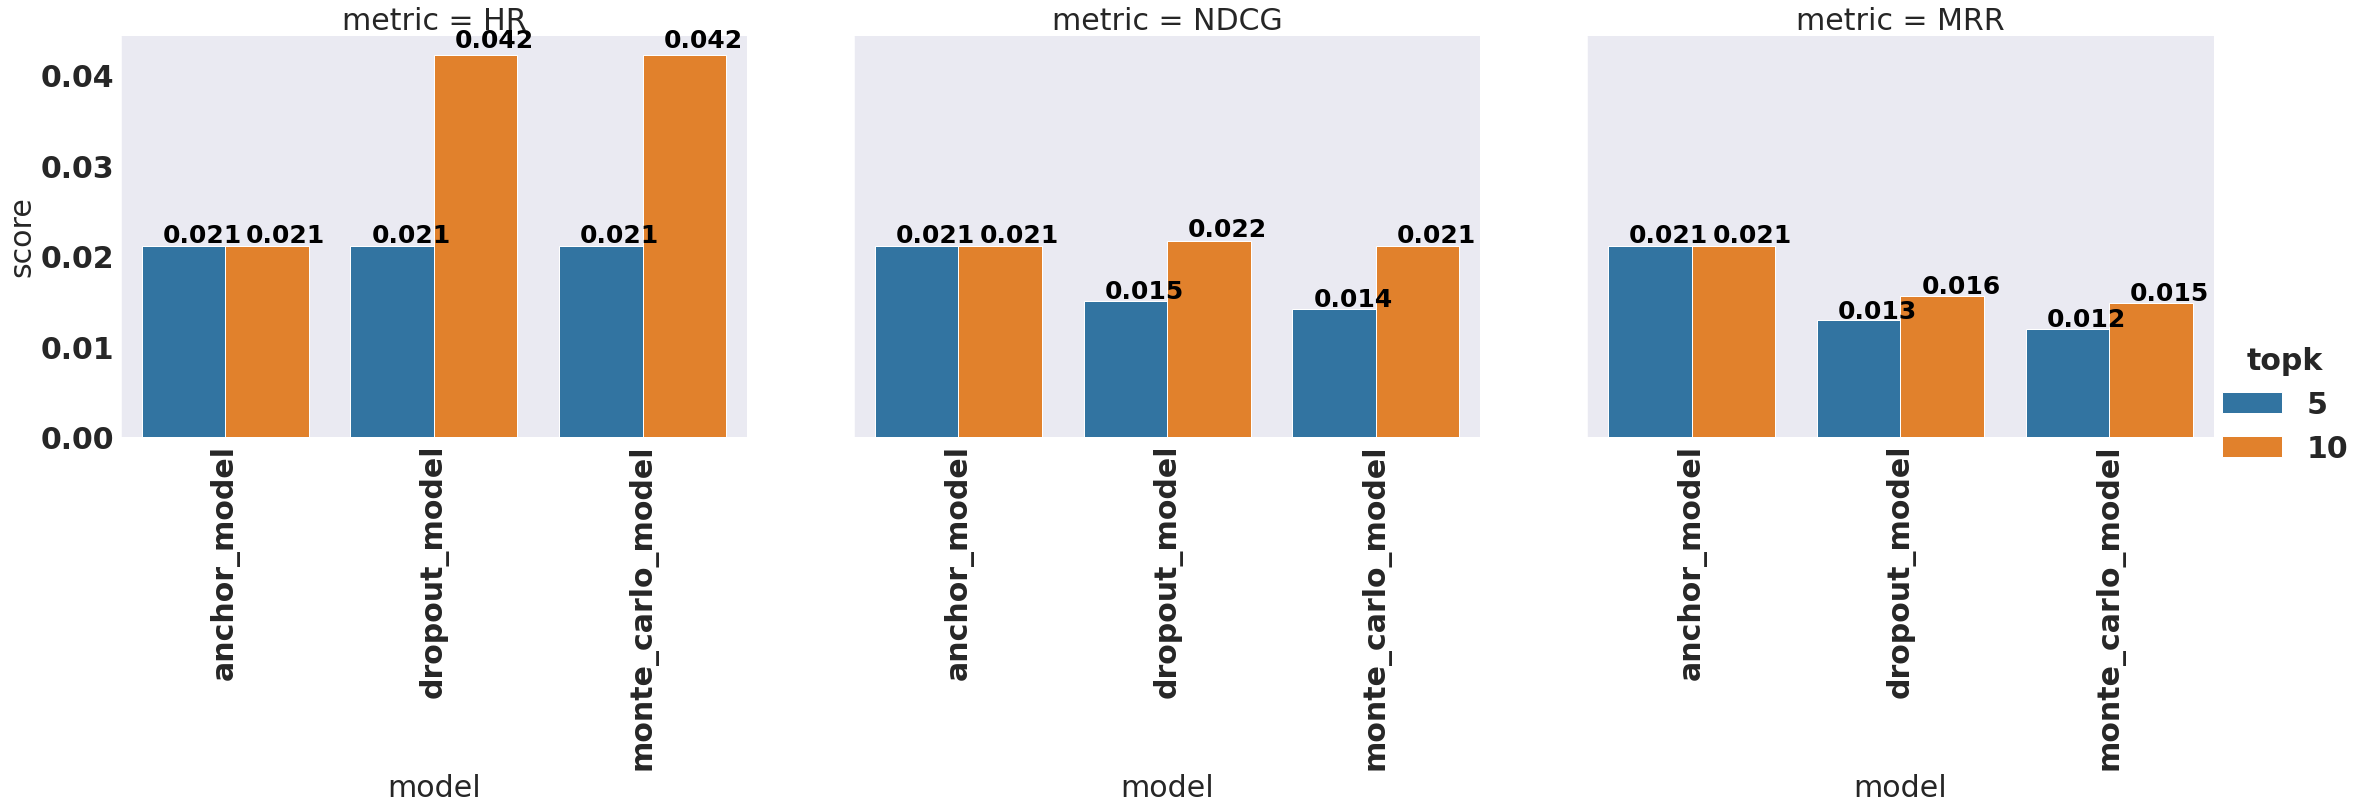

In [ ]:

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 30}

matplotlib.rc('font', **font)
sns.set_style("dark")

g = sns.catplot(x="model", y="score",hue="topk",col="metric",data=results, kind="bar",col_wrap=3,height=7, aspect=1.5,ci=None);
g.fig.subplots_adjust(top=1,right=0.93) 
for i in range(3):
    ax = g.facet_axis(0,i)
    plt.xticks(rotation=90)
    for p in ax.patches:
        ax.text(p.get_x()+0.1, 
                p.get_height() * 1.02, 
               '{0:.3f}'.format(p.get_height()), 
                color='black', 
                rotation='horizontal', 
                size='small')

## referance

anchor paper:

https://data-flair.training/blogs/youtube-video-recommendation-system-ml/

https://github.com/revathijay/Python-Notebooks/blob/master/Recommendation/MovieLens_Youtube_Recommendation_Candidate_Generation_Network.ipynb

https://github.com/hyez/Deep-Youtube-Recommendations/tree/908d2f04120b6041b804e373bd323b75a28b77a6

improvment:

https://towardsdatascience.com/monte-carlo-dropout-7fd52f8b6571

state of the art:

https://arxiv.org/pdf/2108.12184.pdf

https://github.com/usydnlp/Glocal_K
